PyVG: Data Science to predict Video Games sales

Equipe: Alexis Terrasse, Henri-François Mole, Hsan Drissi, Stephane Lelievre

Promo: DS_Oct21

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb
%matplotlib inline 
from sklearn.feature_selection import SelectKBest,SelectFromModel,f_regression
import scipy.stats as stats
import seaborn as sns
from tensorflow.keras.utils import to_categorical


In [15]:
df=pd.read_csv(r'C:\Users\Windows\Documents\GitHub\demo-git\regression_projet\vgsales_eda2_ready.txt')

df=df.set_index('Name')

In [16]:
#Selection des variables logarithmqiues
df_log=df.select_dtypes(['int','float']).drop(['Global_Sales','day','year','month','anom','N_pro','N_user','quarter'],1)



C:\Users\Windows\AppData\Local\Temp/ipykernel_32948/4017969313.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_log=df.select_dtypes(['int','float']).drop(['Global_Sales','day','year','month','anom','N_pro','N_user','quarter'],1)


In [17]:
q=10
#Préparation des données: discretiser la variable Global_Sales_log
df_log['Global_Sales.log']=pd.qcut(df_log['Global_Sales.log'],q=q,labels=[i for i in range(0,q)]).astype('int')


#Nettoyage des données
df_log=df_log.dropna()
df_log=df_log.drop_duplicates()
df_log
print(df_log.shape)

(7835, 70)


In [18]:
#Séparation des données entre variables explicatives et variable cible 

target=df_log['Global_Sales.log']
data=df_log.drop('Global_Sales.log',1)

C:\Users\Windows\AppData\Local\Temp/ipykernel_32948/1727941697.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data=df_log.drop('Global_Sales.log',1)


In [19]:
#normalisation des données
scaler=StandardScaler()
data=pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data.head()


,Score_pro,Score_user,compound,PC,nintendo,playstation,xbox,pub_activision,pub_amc games,pub_capcom,...,genre_Racing,genre_Role-Playing,genre_Sandbox,genre_Shooter,genre_Simulation,genre_Sports,genre_Strategy,genre_Visual+Novel,N_pro.log,N_user.log
0,1.810717,1.314840,0.674182,-0.379864,-0.552825,-0.766576,1.863339,-0.250897,-0.216564,-0.188557,...,-0.286414,-0.341196,-0.011298,-0.37523,-0.217853,-0.38447,-0.226706,-0.042309,1.451320,1.054583
1,1.810717,1.392442,0.661424,2.632520,-0.552825,-0.766576,-0.536671,-0.250897,-0.216564,-0.188557,...,-0.286414,-0.341196,-0.011298,-0.37523,-0.217853,-0.38447,-0.226706,-0.042309,1.110893,2.780530
2,2.047455,0.538812,1.154199,2.632520,-0.552825,-0.766576,-0.536671,-0.250897,-0.216564,-0.188557,...,-0.286414,-0.341196,-0.011298,-0.37523,-0.217853,-0.38447,-0.226706,-0.042309,1.423117,3.221082
3,1.889630,1.314840,0.471174,2.632520,-0.552825,-0.766576,-0.536671,-0.250897,-0.216564,-0.188557,...,-0.286414,-0.341196,-0.011298,-0.37523,-0.217853,-0.38447,-0.226706,-0.042309,0.389548,2.629604
4,1.810717,0.849223,0.501679,2.632520,-0.552825,-0.766576,-0.536671,-0.250897,-0.216564,-0.188557,...,-0.286414,-0.341196,-0.011298,-0.37523,-0.217853,-0.38447,-0.226706,-0.042309,-0.253017,2.249117


In [20]:
#séparation des données en un ensemble d'apprentissage et un ensemble de test contenant 20% des données

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=123)

In [21]:
data.columns

Index(['Score_pro', 'Score_user', 'compound', 'PC', 'nintendo', 'playstation',
       'xbox', 'pub_activision', 'pub_amc games', 'pub_capcom', 'pub_ea games',
       'pub_ea sports', 'pub_electronic arts', 'pub_konami', 'pub_nintendo',
       'pub_scea', 'pub_sega', 'pub_thq', 'pub_ubisoft', 'lic_Final Fantasy',
       'lic_Harry Potter', 'lic_Marvel', 'lic_NBA', 'lic_Others',
       'lic_Prince of Persia', 'lic_Resident Evil', 'lic_Sonic The Hedgehog',
       'lic_Star Wars', 'lic_The Sims', 'lic_Tom Clancy’s', 'lic_WWE',
       'year.release_2001', 'year.release_2002', 'year.release_2003',
       'year.release_2004', 'year.release_2005', 'year.release_2006',
       'year.release_2007', 'year.release_2008', 'year.release_2009',
       'year.release_2010', 'year.release_2011', 'year.release_2012',
       'year.release_2013', 'year.release_2014', 'year.release_2015',
       'year.release_2016', 'year.release_2017', 'year.release_2018',
       'genre_Action-Adventure', 'genre_Adventure',

In [22]:
#instanciation et entrainement du modèle 


clf=LogisticRegression(penalty='none',max_iter=1000)

clf.fit(X_train,y_train)

LogisticRegression(max_iter=1000, penalty='none')

In [23]:
def display_results(model,xtest,ytest,oh=False):
    name= type(model).__name__
    y_pred= model.predict(xtest)
    
    if oh:
        name= model._name
        y_pred= np.argmax(y_pred,axis=1)
        ytestoh= to_categorical(ytest, dtype = 'int')
        score= model.evaluate(xtest,ytestoh, verbose= 0)[1]
    else:
        name= type(model).__name__
        score= model.score(xtest, ytest)
        
    clf_report = classification_report(y_pred, ytest, output_dict=True)
    cnf_matrix= confusion_matrix(y_pred,ytest)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 3]})
    fig.suptitle('Résultats du model '+name+' - Accuracy (test): '+str(round(score,2)), fontsize=15)

    # Classification report
    sns.heatmap( pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap= 'GnBu', cbar=False,ax=axes[0])
    axes[0].set_title('Rapport de classification')

    # Confusion matrix
    s= sns.heatmap(cnf_matrix, annot=True, fmt=".0f",cmap= "rocket_r",ax=axes[1]) 
    s.set(xlabel='Score prédit', ylabel='Score réel')
    axes[1].set_title('Matrice de confusion')
    filename= name+'_'+'acc_'+str(round(score,2))+'.png'
    plt.savefig(filename)

In [82]:
#prédiction
y_pred=clf.predict(X_test)

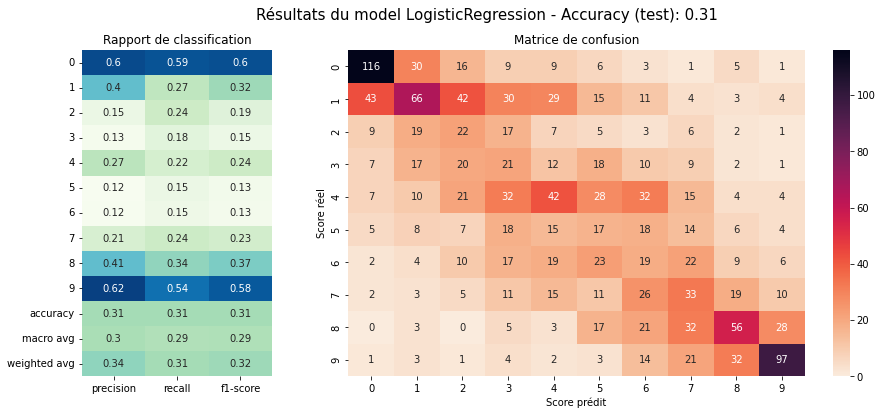

In [24]:
display_results(clf,X_test,y_test,oh=False)

In [84]:
print('score sur l echantillon d aprentissage:',clf.score(X_train,y_train))
print('score sur l echantillon de test:',clf.score(X_test,y_test))
print(classification_report(y_test,y_pred))

score sur l echantillon d aprentissage: 0.3452456924058711
score sur l echantillon de test: 0.3126994256541161
              precision    recall  f1-score   support

           0       0.59      0.60      0.60       192
           1       0.27      0.40      0.32       163
           2       0.24      0.15      0.19       144
           3       0.18      0.13      0.15       164
           4       0.22      0.27      0.24       153
           5       0.16      0.13      0.14       143
           6       0.14      0.12      0.13       157
           7       0.25      0.21      0.23       157
           8       0.34      0.41      0.37       138
           9       0.54      0.62      0.58       156

    accuracy                           0.31      1567
   macro avg       0.29      0.30      0.29      1567
weighted avg       0.30      0.31      0.30      1567



Régression Logistique avec Grid Search

In [27]:
#pca=PCA()
logistic_Reg=LogisticRegression()

C=np.logspace(-4,4,50)
penalty=['l2','l1','elasticnet']
solver=['newton-cg','lbfgs','liblinear','sag','saga'],

params={'C':C,
        'max_iter':[1000],
        'penalty':penalty,
        'solver':solver,
        }

In [28]:
grid=GridSearchCV(logistic_Reg,params)
#grid.fit(X_train,y_train)
grid.fit(X_train,y_train)

c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-0...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'max_iter': [1000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [29]:
grid.score(X_train,y_train)

0.3428525845564773

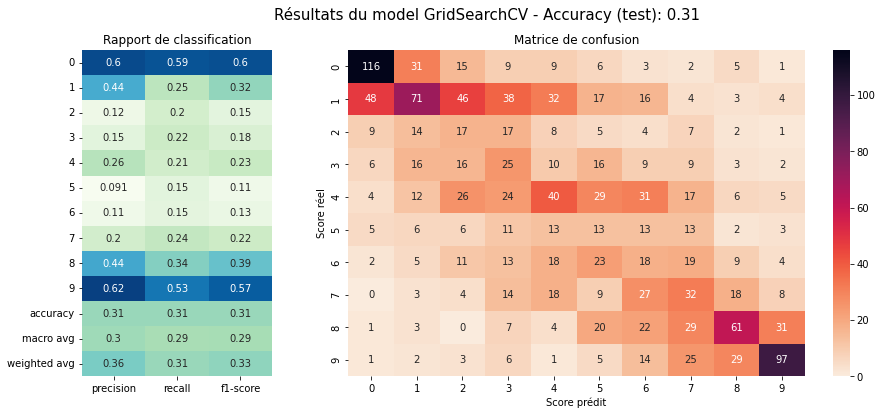

In [30]:
display_results(grid,X_test,y_test,oh=False)